In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import HustleStatsBoxScore, BoxScoreTraditionalV2
from nba_api.stats.endpoints import LeagueGameFinder
import random
import time
from requests.exceptions import ReadTimeout

In [2]:
def fetch_game_ids(season):
    game_finder = LeagueGameFinder(season_nullable=season)
    games = game_finder.get_data_frames()[0]
    return games["GAME_ID"].unique()

In [3]:
def fetch_hustle_stats(game_id):
    hustle_stats = HustleStatsBoxScore(game_id=game_id)
    hustle_data = hustle_stats.get_data_frames()
    player_stats = hustle_data[0]
    team_stats = hustle_data[1] 
    return player_stats, team_stats

In [4]:
def fetch_traditional_stats(game_id):
    traditional_stats = BoxScoreTraditionalV2(game_id=game_id)
    team_stats = traditional_stats.get_data_frames()[1]
    return team_stats


In [23]:
def exponential_backoff_retry(func, *args, max_retries=5, initial_wait=1, multiplier=2, **kwargs):
    wait_time = initial_wait
    for attempt in range(max_retries):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Error: {e}. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
                wait_time *= multiplier
            else:
                raise e
def fetch_hustle_stats_with_retry(game_id):
    hustle_stats = exponential_backoff_retry(HustleStatsBoxScore, game_id=game_id)
    data_frames = hustle_stats.get_data_frames()
    
    if len(data_frames) >= 2:
        player_stats = data_frames[0]
        team_stats = data_frames[1]
        return player_stats, team_stats
    else:
        raise ValueError(f"Unexpected number of data frames returned for game {game_id}.")
def fetch_traditional_stats_with_retry(game_id):
    traditional_stats = exponential_backoff_retry(BoxScoreTraditionalV2, game_id=game_id)
    data_frames = traditional_stats.get_data_frames()
    
    # Safely extract the team stats data frame
    if len(data_frames) >= 2:
        team_stats = data_frames[1]  # Team-level data
        return team_stats
    else:
        raise ValueError(f"Unexpected number of data frames returned for game {game_id}.")

In [24]:
def merge_hustle_and_plus_minus(game_id):
    player_stats, hustle_team_stats = fetch_hustle_stats_with_retry(game_id)
    traditional_team_stats = fetch_traditional_stats_with_retry(game_id)

    hustle_team_stats["TEAM_ID"] = hustle_team_stats["TEAM_ID"].astype(str)
    traditional_team_stats["TEAM_ID"] = traditional_team_stats["TEAM_ID"].astype(str)

    merged = pd.merge(hustle_team_stats, traditional_team_stats, on="TEAM_ID", suffixes=("_HUSTLE", "_TRAD"))
    return merged

In [25]:
def calculate_game_correlations(merged_data):
    hustle_columns = [
        "CONTESTED_SHOTS", "DEFLECTIONS", "CHARGES_DRAWN", "SCREEN_ASSISTS", 
        "OFF_LOOSE_BALLS_RECOVERED", "DEF_LOOSE_BALLS_RECOVERED", "BOX_OUTS"
    ]
    correlation_results = {}
    for stat in hustle_columns:
        if stat in merged_data.columns:
            correlation = merged_data[stat].corr(merged_data["PLUS_MINUS"])
            correlation_results[stat] = correlation
    return correlation_results

In [26]:
def analyze_season(season):
    game_ids = fetch_game_ids(season)
    season_correlations = []

    for game_id in game_ids:
        try:
            merged_data = merge_hustle_and_plus_minus(game_id)
            game_correlations = calculate_game_correlations(merged_data)
            season_correlations.append(game_correlations)
        except Exception as e:
            print(f"Error processing game {game_id}: {e}")

    season_correlation_df = pd.DataFrame(season_correlations)
    mean_correlation = season_correlation_df.mean()
    return mean_correlation

In [33]:
def visualize_season_correlations(correlations):
    import seaborn as sns
    
    # Sort the correlations in descending order
    sorted_correlations = correlations.sort_values(ascending=False)
    
    # Create a heatmap
    plt.figure(figsize=(8, 12))
    sns.heatmap(
        sorted_correlations.to_frame(),
        annot=True,
        cmap="coolwarm",
        cbar=True,
        linewidths=0.5
    )
    plt.title('Season-Wide Correlation of Hustle Stats with +/- (Sorted)')
    plt.xlabel('Correlation')
    plt.yticks(rotation=0)
    plt.tight_layout()
    return plt

In [28]:
SEASON = "2024-25"
season_correlation = analyze_season(SEASON)

NameError: name 'visualize_season_correlation' is not defined

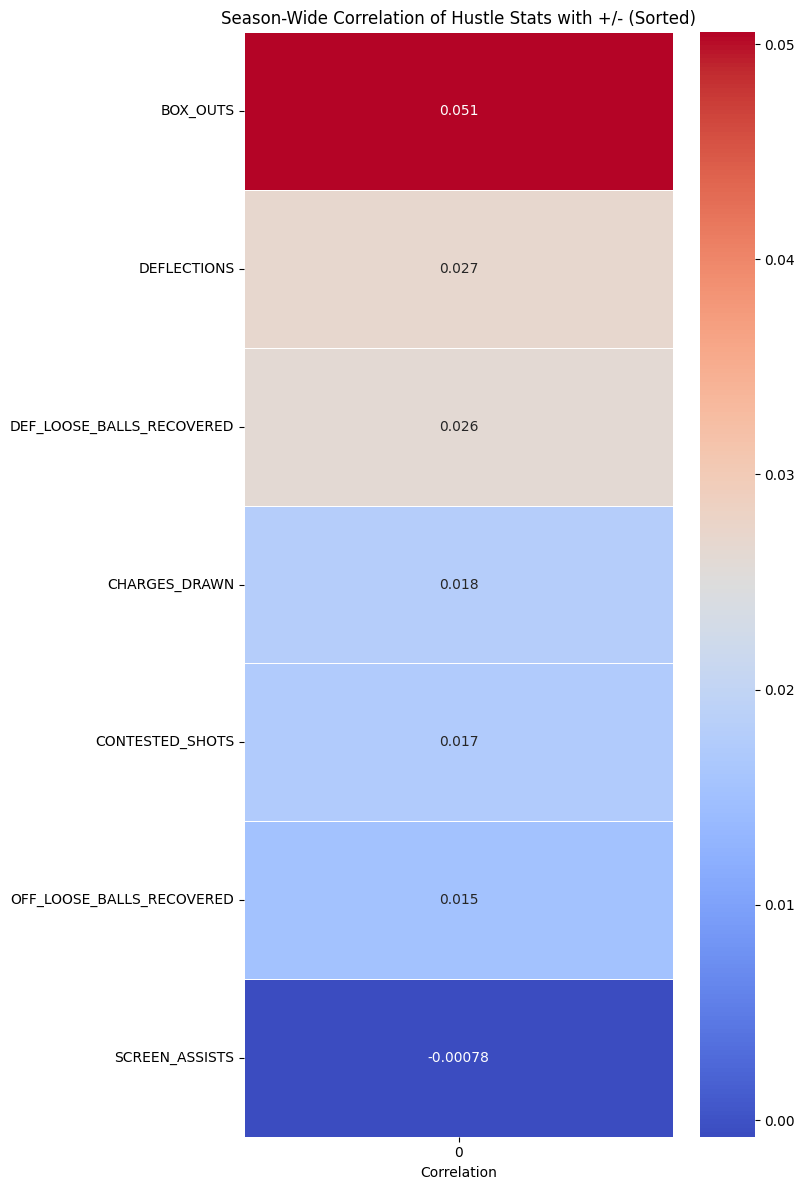

In [34]:
plt = visualize_season_correlations(season_correlation)

# Takeaways
- No specific HUSTLE stat has much impact at all on overall team +- (No specific stat has high enough correlation value)
- We find much more correlation with general stats